In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),])
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False, num_workers=1)
validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False, num_workers=1)

train_data = []
train_label = []
val_data = []
val_label = []

for i, data in enumerate(trainloader):
    inputs, labels = data
    train_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
#         image = np.vstack((image, np.ones(1)))
        if j == 0:
            train_data_batch = image
        else:
            train_data_batch = np.hstack((train_data_batch,image))
    if i == 0:
        train_data = train_data_batch
    else:
        train_data = np.hstack((train_data,train_data_batch))
    train_label = train_label+labels.tolist()
train_label = np.array(train_label)
train_label = train_label.reshape((len(train_label),1))

for i, data in enumerate(valloader):
    inputs, labels = data
    val_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
#         image = np.vstack((image, np.ones(1)))
        if j == 0:
            val_data_batch = image
        else:
            val_data_batch = np.hstack((val_data_batch,image))
    if i == 0:
        val_data = val_data_batch
    else:
        val_data = np.hstack((val_data,val_data_batch))
    val_label = val_label+labels.tolist()
val_label = np.array(val_label)
val_label = val_label.reshape((len(val_label),1))

In [13]:
train_label.shape

(1027, 1)

In [3]:
def sigmoid(x):
    sig = 1/(1+np.exp(-x))
    return sig

In [31]:
def lossFunc(label, h, reg_rate):
    m = len(label)
    loss = (-1/m)*np.sum(label*np.log(sigmoid(h.T)) + (1-label)*np.log(1-sigmoid(h.T)))
    reg = reg_rate/(2*m)*
    return loss

In [167]:
def accuracyFunc(h):
    return h.T >= 0.5

In [211]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []

class deepNetwork:
    def __init__(self, inputNode, hidden_1, hidden_2, learningrate, activation, reg_rate):
        self.inodes = inputNode
        self.h1 = hidden_1
        self.h2 = hidden_2
#         self.onodes = outputNode
        self.lr = learningrate
        self.af = activation
        self.rr = reg_rate
        m = len(self.inodes[0]) #라벨개수
        #가중치
        np.random.seed(0)
        self.w1 = np.random.normal(0.0, pow(self.h1, -0.5),(len(self.inodes), self.h1))
        self.w2 = np.random.normal(0.0, pow(self.h2, -0.5),(self.h1, self.h2))
        self.w3 = np.random.normal(0.0, pow(1, -0.5),(self.h2, 1))
        
        
#         self.w1 = np.random.normal(size = (len(self.inodes), self.h1))
#         self.w2 = np.random.normal(size =(self.h1, self.h2))
#         self.w3 = np.random.normal(size =(self.h2, 1))

            
        self.b1 = 1
        self.b2 = 1
        self.b3 = 1
    
    def train(self, label):
        iterations = 0
        m = len(label)
        loss_old = 0
        while(True):
            iterations+=1            
            z1 = np.dot(self.w1.T, self.inodes) + self.b1
            a1 = self.af(z1)

            z2 = np.dot(self.w2.T, a1) + self.b2
            a2 = self.af(z2) #(h2,1027)

            z3 = np.dot(self.w3.T, a2)+self.b3            
            a3 = self.af(z3) # 예측값 (1,1027)
            
            z1_val = np.dot(self.w1.T, val_data)
            a1_val = self.af(z1_val)

            z2_val = np.dot(self.w2.T, a1_val)
            a2_val = self.af(z2_val) #(h2,1027)

            z3_val = np.dot(self.w3.T, a2_val)           
            a3_val = self.af(z3_val) # 예측값 (1,1027)
            
            loss = lossFunc(label, a3) # 손실
            loss_val = lossFunc(val_label,a3_val)
            accuracy = (accuracyFunc(a3) == label).sum() / m
            accuracy_val=(accuracyFunc(a3_val) == val_label).sum() / len(val_label)
#             print("accuracy", accuracy)
            if abs(loss_old-loss)< 1e-5:
                break
            loss_old = loss
            loss_list_train.append(loss_old)
            loss_list_val.append(loss_val)
            accuracy_list_train.append(accuracy)
            accuracy_list_val.append(accuracy_val)
            
            
#             print("#",iterations,": ",loss)
            
            # 가중치 업데이트
            #w3:(h2,1) / w2:(h1,h2) / w1:(10000,h1)
            w3_update = -label.T + a3  #(1,1027)
            w2_update = np.dot(w3_update.T, self.w3.T).T * (a2*(1-a2)) #(h2,1027) 
#             w2_update = np.dot(np.dot(np.dot(w3_update.T, self.w3.T), a2), (1-a2).T) # (1027,h2)
            w1_update = np.dot(w2_update.T, self.w2.T).T * (a1*(1-a1)) #(h1, 1027)
#             w1_update = np.dot(np.dot(np.dot(w2_update, self.w2.T), a1), (1-a1).T) #(1027, h1)
            self.w3 = self.w3 -(self.lr/m)*np.dot(w3_update, a2.T).T
            self.w2 = self.w2 -(self.lr/m)*np.dot(w2_update, a1.T).T
            self.w1 = self.w1 -(self.lr/m)*np.dot(w1_update, self.inodes.T).T
            
            self.b3 = self.b3 - (self.lr/m)*w3_update
            self.b2 = self.b2 - (self.lr/m)*w2_update
            self.b1 = self.b1 - (self.lr/m)*w1_update
#             if iterations == 10:
#                 break

In [213]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
n = deepNetwork(train_data, 80, 20, 0.05, sigmoid)
n.train(train_label)

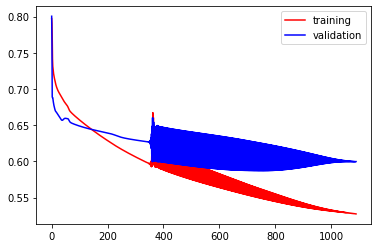

In [214]:
plt.plot(loss_list_train,label='training',color= 'r')
plt.plot(loss_list_val,label='validation',color = 'b')
plt.legend()
plt.show()

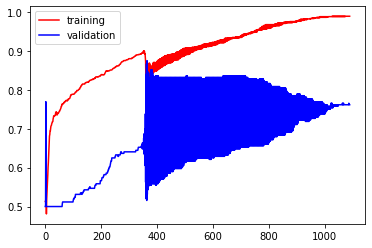

In [215]:
plt.plot(accuracy_list_train,label='training', color='r')
plt.plot(accuracy_list_val,label='validation',color='b')
plt.legend()
plt.show()

In [216]:
from pandas import Series, DataFrame
import pandas as pd

In [217]:
data = [[loss_list_train[-1], accuracy_list_train[-1]],
        [loss_list_val[-1], accuracy_list_val[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame

,Loss,Accruacy
Training,0.527444,0.989289
Validation,0.599641,0.761719
